**Example of Coordinate Based HP-Lattice model**

by: Hanna Linn

In [1]:
%load_ext autoreload
%autoreload 2

import pennylane as qml
import math
from pennylane import qaoa
from pennylane import numpy as np
import matplotlib.pyplot as plt
from vqa.hamiltonian.protein_folding import protein_folding_hamiltonian
from vqa.hamiltonian.Protein_models.CoordinateBased_HPLattice import CoordinateBased_HPLattice
from vqa.utils.protein_utils import *


In [2]:
# Make an instance for the protein
sequence = [1,0,0,1] #HPPH
L1 = 2
L2 = 2

lambda_vector = (2.1, 2.4, 3)

protein = CoordinateBased_HPLattice((L1, L2), sequence = sequence, lambda_vector = lambda_vector)
print(protein)
protein.calc_solution_sets()
feasible_set = np.array(protein.feasible_set)


O:
[-2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1, -2.1]
T:
[[ 0.   4.2  0.   0.   2.4  0.  -1.  -1. ]
 [ 4.2  0.   0.   0.   0.   2.4 -1.  -1. ]
 [ 0.   0.   0.   4.2  0.   0.   2.4  0. ]
 [ 0.   0.   4.2  0.   0.   0.   0.   2.4]
 [ 2.4  0.   0.   0.   0.   4.2  0.   0. ]
 [ 0.   2.4  0.   0.   4.2  0.   0.   0. ]
 [-1.  -1.   2.4  0.   0.   0.   0.   4.2]
 [-1.  -1.   0.   2.4  0.   0.   4.2  0. ]]
Dn:
[2, 2, 2, 2]


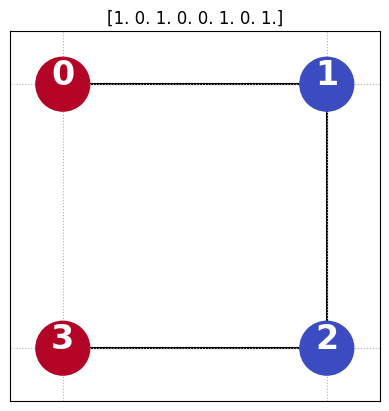

In [3]:
# Draw the protein
protein.viz_lattice(feasible_set[0])

[1. 0. 1. 0. 0. 1. 0. 1.]
[1. 0. 0. 1. 0. 1. 1. 0.]
[0. 1. 1. 0. 1. 0. 0. 1.]
[0. 1. 0. 1. 1. 0. 1. 0.]


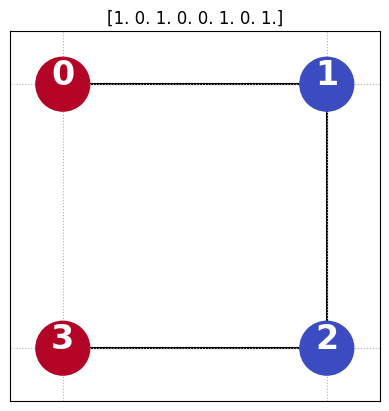

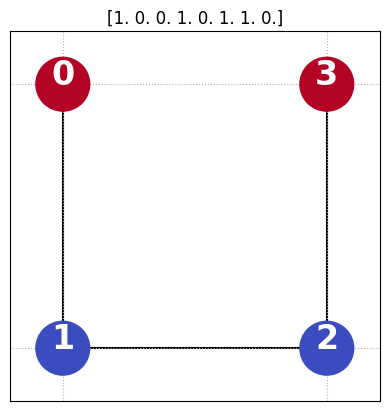

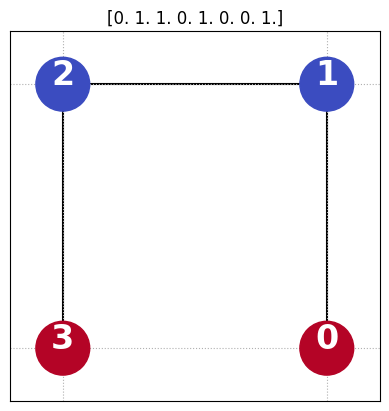

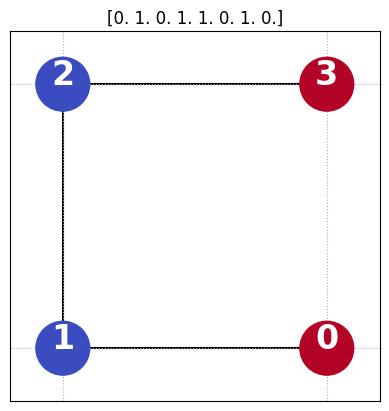

In [4]:
# Draw all proteins in feasible solution set
for j,i in enumerate(feasible_set):
    plt.figure(j)
    protein.viz_lattice(i)
    print(i)

In [5]:
# Make into Hamiltonian
H_cost = protein_folding_hamiltonian(protein)
num_qubits = protein.num_bits
qubits = range(protein.num_bits)

H_mixer = qaoa.x_mixer(qubits)

print('H_cost:\n' + str(H_cost))
print()
print('H_mixer:\n' + str(H_mixer))

H_cost:
  (-0.6) [Z4]
+ (-0.6) [Z5]
+ (-0.6) [Z2]
+ (-0.6) [Z3]
+ (-0.09999999999999998) [Z6]
+ (-0.09999999999999998) [Z7]
+ (-0.09999999999999998) [Z0]
+ (-0.09999999999999998) [Z1]
+ (-0.25) [Z0 Z6]
+ (-0.25) [Z0 Z7]
+ (-0.25) [Z1 Z6]
+ (-0.25) [Z1 Z7]
+ (0.0) [Z0 Z2]
+ (0.0) [Z0 Z3]
+ (0.0) [Z0 Z5]
+ (0.0) [Z1 Z2]
+ (0.0) [Z1 Z3]
+ (0.0) [Z1 Z4]
+ (0.0) [Z2 Z4]
+ (0.0) [Z2 Z5]
+ (0.0) [Z2 Z7]
+ (0.0) [Z3 Z4]
+ (0.0) [Z3 Z5]
+ (0.0) [Z3 Z6]
+ (0.0) [Z4 Z6]
+ (0.0) [Z4 Z7]
+ (0.0) [Z5 Z6]
+ (0.0) [Z5 Z7]
+ (0.6) [Z0 Z4]
+ (0.6) [Z1 Z5]
+ (0.6) [Z2 Z6]
+ (0.6) [Z3 Z7]
+ (1.05) [Z0 Z1]
+ (1.05) [Z2 Z3]
+ (1.05) [Z4 Z5]
+ (1.05) [Z6 Z7]

H_mixer:
  (1) [X0]
+ (1) [X1]
+ (1) [X2]
+ (1) [X3]
+ (1) [X4]
+ (1) [X5]
+ (1) [X6]
+ (1) [X7]


In [10]:
dev = qml.device('default.qubit', wires = qubits)

# Put the Mixer and Cost Hamiltonians in a layer so that we can repeat it
def qaoa_layer(gamma, beta):
    qaoa.cost_layer(gamma, H_cost)
    qaoa.mixer_layer(beta, H_mixer)
    
# Then repeat it in a circuit with starting in a super position of all bitstrings
def circuit(params):     # Gamma and Beta values can be put together to be an array of parameters
    for q in qubits:     # To start in a superposition we place a Hadamard on all qubits
        qml.Hadamard(wires = q)
    qml.layer(qaoa_layer, len(params[0]), params[0], params[1])
    

# If we add a expectation value we get a cost function for average cost of the cost Hamiltonian for given parameters
@qml.qnode(dev)
def average_cost(params):
    circuit(params)
    return qml.expval(H_cost)

# Obtains the probability for all the states
@qml.qnode(dev)
def get_probs(params):
    circuit(params)
    return qml.probs(wires = qubits)

# CVaR function for known energies and probabilities
def CVaR(params):
    alpha = 0.25
    circuit(params)
    
    Energy_list = get_energies_index_states(H_cost)
    Energy_array = np.column_stack((Energy_list, get_probs(params)))
    Energy_array = Energy_array[Energy_array[:, 0].argsort()]
    
    Energy_vector = Energy_array[0:math.ceil(len(Energy_list)*alpha),0]
    Probability_vector = Energy_array[0:math.ceil(len(Energy_list)*alpha),1]

    exp_CVaR = np.dot(Energy_vector, Probability_vector)
    return exp_CVaR



# Let's test it!
zero_parameters = np.array([[0],[0]])
half_parameters = np.array([[0.5],[0.5]])
test_parameters = np.array([[0.1],[0.1]])
p = 1

print('Average cost with gamma=0 and beta=0:\n', average_cost(zero_parameters))
print('CVaR cost with gamma=0 and beta=0 and alpha=0.25:\n', CVaR(zero_parameters))
print('Average cost with gamma=0.5 and beta=0.5:\n', average_cost(half_parameters))
print('CVaR cost with gamma=0.5 and beta=0.5 and alpha=0.25:\n', CVaR(half_parameters))
print('Average cost with gamma=0.1 and beta=0.1:\n', average_cost(test_parameters))
print('CVaR cost with gamma=0.1 and beta=0.1 and alpha=0.25:\n', CVaR(test_parameters))
# Draw our circuit
print()
print(qml.draw(average_cost, expansion_strategy = 'device')(zero_parameters))

Average cost with gamma=0 and beta=0:
 1.1102230246251565e-16
[ 2.8  0.7  0.7  2.8  0.7 -1.4 -1.4  0.7  0.7 -1.4 -1.4  0.7  2.8  0.7
  0.7  2.8  0.7  1.  -1.4  3.1 -1.4 -1.1 -3.5  1.  -1.4 -1.1 -3.5  1.
  0.7  1.  -1.4  3.1  0.7 -1.4  1.   3.1 -1.4 -3.5 -1.1  1.  -1.4 -3.5
 -1.1  1.   0.7 -1.4  1.   3.1  2.8  3.1  3.1  7.6  0.7  1.   1.   5.5
  0.7  1.   1.   5.5  2.8  3.1  3.1  7.6  0.7 -2.4 -2.4 -1.3  1.  -2.1
 -2.1 -1.  -1.4 -4.5 -4.5 -3.4  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.
 -1.1 -1.8 -4.2 -0.7 -3.5 -4.2 -6.6 -3.1  1.   0.3 -2.1  1.4 -1.4 -4.5
 -2.1 -1.  -1.1 -4.2 -1.8 -0.7 -3.5 -6.6 -4.2 -3.1  1.  -2.1  0.3  1.4
  0.7  0.   0.   3.5  1.   0.3  0.3  3.8 -1.4 -2.1 -2.1  1.4  3.1  2.4
  2.4  5.9  0.7 -2.4 -2.4 -1.3 -1.4 -4.5 -4.5 -3.4  1.  -2.1 -2.1 -1.
  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.  -3.5 -4.2 -6.6 -3.1 -1.1 -1.8
 -4.2 -0.7  1.   0.3 -2.1  1.4 -1.4 -4.5 -2.1 -1.  -3.5 -6.6 -4.2 -3.1
 -1.1 -4.2 -1.8 -0.7  1.  -2.1  0.3  1.4  0.7  0.   0.   3.5 -1.4 -2.1
 -2.1  1.4  1.   0

Average cost with gamma=0.5 and beta=0.5:
 4.081772386022926
[ 2.8  0.7  0.7  2.8  0.7 -1.4 -1.4  0.7  0.7 -1.4 -1.4  0.7  2.8  0.7
  0.7  2.8  0.7  1.  -1.4  3.1 -1.4 -1.1 -3.5  1.  -1.4 -1.1 -3.5  1.
  0.7  1.  -1.4  3.1  0.7 -1.4  1.   3.1 -1.4 -3.5 -1.1  1.  -1.4 -3.5
 -1.1  1.   0.7 -1.4  1.   3.1  2.8  3.1  3.1  7.6  0.7  1.   1.   5.5
  0.7  1.   1.   5.5  2.8  3.1  3.1  7.6  0.7 -2.4 -2.4 -1.3  1.  -2.1
 -2.1 -1.  -1.4 -4.5 -4.5 -3.4  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.
 -1.1 -1.8 -4.2 -0.7 -3.5 -4.2 -6.6 -3.1  1.   0.3 -2.1  1.4 -1.4 -4.5
 -2.1 -1.  -1.1 -4.2 -1.8 -0.7 -3.5 -6.6 -4.2 -3.1  1.  -2.1  0.3  1.4
  0.7  0.   0.   3.5  1.   0.3  0.3  3.8 -1.4 -2.1 -2.1  1.4  3.1  2.4
  2.4  5.9  0.7 -2.4 -2.4 -1.3 -1.4 -4.5 -4.5 -3.4  1.  -2.1 -2.1 -1.
  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.  -3.5 -4.2 -6.6 -3.1 -1.1 -1.8
 -4.2 -0.7  1.   0.3 -2.1  1.4 -1.4 -4.5 -2.1 -1.  -3.5 -6.6 -4.2 -3.1
 -1.1 -4.2 -1.8 -0.7  1.  -2.1  0.3  1.4  0.7  0.   0.   3.5 -1.4 -2.1
 -2.1  1.4  1.   0.

Average cost with gamma=0.1 and beta=0.1:
 0.5241447225238747
[ 2.8  0.7  0.7  2.8  0.7 -1.4 -1.4  0.7  0.7 -1.4 -1.4  0.7  2.8  0.7
  0.7  2.8  0.7  1.  -1.4  3.1 -1.4 -1.1 -3.5  1.  -1.4 -1.1 -3.5  1.
  0.7  1.  -1.4  3.1  0.7 -1.4  1.   3.1 -1.4 -3.5 -1.1  1.  -1.4 -3.5
 -1.1  1.   0.7 -1.4  1.   3.1  2.8  3.1  3.1  7.6  0.7  1.   1.   5.5
  0.7  1.   1.   5.5  2.8  3.1  3.1  7.6  0.7 -2.4 -2.4 -1.3  1.  -2.1
 -2.1 -1.  -1.4 -4.5 -4.5 -3.4  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.
 -1.1 -1.8 -4.2 -0.7 -3.5 -4.2 -6.6 -3.1  1.   0.3 -2.1  1.4 -1.4 -4.5
 -2.1 -1.  -1.1 -4.2 -1.8 -0.7 -3.5 -6.6 -4.2 -3.1  1.  -2.1  0.3  1.4
  0.7  0.   0.   3.5  1.   0.3  0.3  3.8 -1.4 -2.1 -2.1  1.4  3.1  2.4
  2.4  5.9  0.7 -2.4 -2.4 -1.3 -1.4 -4.5 -4.5 -3.4  1.  -2.1 -2.1 -1.
  3.1  0.  -0.   1.1 -1.4 -2.1 -4.5 -1.  -3.5 -4.2 -6.6 -3.1 -1.1 -1.8
 -4.2 -0.7  1.   0.3 -2.1  1.4 -1.4 -4.5 -2.1 -1.  -3.5 -6.6 -4.2 -3.1
 -1.1 -4.2 -1.8 -0.7  1.  -2.1  0.3  1.4  0.7  0.   0.   3.5 -1.4 -2.1
 -2.1  1.4  1.   0

In [7]:
# Optimisation of the circuit

optimiser = qml.GradientDescentOptimizer()
steps = 100
initial_params = np.array([[0.5, 0.5], [0.5, 0.5]], requires_grad = True)
p = 2

cost_vector = np.zeros(steps)
cost_vector[0] = CVaR(initial_params)
params_vector = np.zeros((steps, 2, p))

params = initial_params
for i in range(steps):
    params_vector[i] = params
    params, cost_ = optimiser.step_and_cost(CVaR, params)
    cost_vector[i] = cost_

best_params_optimisation = params
print('Optimal parameters:\n', best_params_optimisation)
print('Average cost for the best parameters:\n', average_cost(best_params_optimisation))

[[-6.60000000e+00  5.68552819e-04]
 [-6.60000000e+00  5.68552819e-04]
 [-6.60000000e+00  5.68552819e-04]
 [-6.60000000e+00  5.68552819e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.50000000e+00  2.63608393e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-4.20000000e+00  9.27431604e-04]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.50000000e+00  1.45708046e-03]
 [-3.40000000e+00  1

Autograd ArrayBox with value [[-6.60000000e+00  7.06676468e-04]
 [-6.60000000e+00  7.06676468e-04]
 [-6.60000000e+00  7.06676468e-04]
 [-6.60000000e+00  7.06676468e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.50000000e+00  2.93782087e-04]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-4.20000000e+00  1.12220504e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468992e-03]
 [-3.50000000e+00  1.54468

Autograd ArrayBox with value [[-6.60000000e+00  8.91004629e-04]
 [-6.60000000e+00  8.91004629e-04]
 [-6.60000000e+00  8.91004629e-04]
 [-6.60000000e+00  8.91004629e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.50000000e+00  3.34864981e-04]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-4.20000000e+00  1.37279444e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908334e-03]
 [-3.50000000e+00  1.62908

Autograd ArrayBox with value [[-6.60000000e+00  1.14018414e-03]
 [-6.60000000e+00  1.14018414e-03]
 [-6.60000000e+00  1.14018414e-03]
 [-6.60000000e+00  1.14018414e-03]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.50000000e+00  3.93307703e-04]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-4.20000000e+00  1.69724670e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389401e-03]
 [-3.50000000e+00  1.70389

Autograd ArrayBox with value [[-6.60000000e+00  1.48042629e-03]
 [-6.60000000e+00  1.48042629e-03]
 [-6.60000000e+00  1.48042629e-03]
 [-6.60000000e+00  1.48042629e-03]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.50000000e+00  4.78870548e-04]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-4.20000000e+00  2.11895465e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990538e-03]
 [-3.50000000e+00  1.75990

Autograd ArrayBox with value [[-6.60000000e+00  1.94738943e-03]
 [-6.60000000e+00  1.94738943e-03]
 [-6.60000000e+00  1.94738943e-03]
 [-6.60000000e+00  1.94738943e-03]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.50000000e+00  6.05135778e-04]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-4.20000000e+00  2.66767087e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497345e-03]
 [-3.50000000e+00  1.78497

Autograd ArrayBox with value [[-6.60000000e+00  2.58667243e-03]
 [-6.60000000e+00  2.58667243e-03]
 [-6.60000000e+00  2.58667243e-03]
 [-6.60000000e+00  2.58667243e-03]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.50000000e+00  7.88308811e-04]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-4.20000000e+00  3.38057172e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517243e-03]
 [-3.50000000e+00  1.76517

Autograd ArrayBox with value [[-6.60000000e+00  3.45044464e-03]
 [-6.60000000e+00  3.45044464e-03]
 [-6.60000000e+00  3.45044464e-03]
 [-6.60000000e+00  3.45044464e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.50000000e+00  1.04201567e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-4.20000000e+00  4.30337611e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809174e-03]
 [-3.50000000e+00  1.68809

Autograd ArrayBox with value [[-6.60000000e+00  4.58735576e-03]
 [-6.60000000e+00  4.58735576e-03]
 [-6.60000000e+00  4.58735576e-03]
 [-6.60000000e+00  4.58735576e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.50000000e+00  1.36601203e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-4.20000000e+00  5.49045086e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861763e-03]
 [-3.50000000e+00  1.54861

Autograd ArrayBox with value [[-6.60000000e+00  6.02650136e-03]
 [-6.60000000e+00  6.02650136e-03]
 [-6.60000000e+00  6.02650136e-03]
 [-6.60000000e+00  6.02650136e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.50000000e+00  1.73122133e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-4.20000000e+00  6.99927657e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539424e-03]
 [-3.50000000e+00  1.35539

Autograd ArrayBox with value [[-6.60000000e+00  7.76630242e-03]
 [-6.60000000e+00  7.76630242e-03]
 [-6.60000000e+00  7.76630242e-03]
 [-6.60000000e+00  7.76630242e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.50000000e+00  2.07331419e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-4.20000000e+00  8.87105441e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312888e-03]
 [-3.50000000e+00  1.13312

Autograd ArrayBox with value [[-6.60000000e+00  9.78667850e-03]
 [-6.60000000e+00  9.78667850e-03]
 [-6.60000000e+00  9.78667850e-03]
 [-6.60000000e+00  9.78667850e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.50000000e+00  2.31123399e-03]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-4.20000000e+00  1.10977807e-02]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924807e-04]
 [-3.50000000e+00  9.15924

Autograd ArrayBox with value [[-6.60000000e+00  1.20858306e-02]
 [-6.60000000e+00  1.20858306e-02]
 [-6.60000000e+00  1.20858306e-02]
 [-6.60000000e+00  1.20858306e-02]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.50000000e+00  2.38723112e-03]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-4.20000000e+00  1.36012042e-02]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763540e-04]
 [-3.50000000e+00  7.33763

Autograd ArrayBox with value [[-6.60000000e+00  1.47056674e-02]
 [-6.60000000e+00  1.47056674e-02]
 [-6.60000000e+00  1.47056674e-02]
 [-6.60000000e+00  1.47056674e-02]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.50000000e+00  2.29484584e-03]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-4.20000000e+00  1.62524477e-02]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268578e-04]
 [-3.50000000e+00  6.02268

Autograd ArrayBox with value [[-6.60000000e+00  1.77055996e-02]
 [-6.60000000e+00  1.77055996e-02]
 [-6.60000000e+00  1.77055996e-02]
 [-6.60000000e+00  1.77055996e-02]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.50000000e+00  2.06955913e-03]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-4.20000000e+00  1.89152653e-02]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841183e-04]
 [-3.50000000e+00  5.22841

Autograd ArrayBox with value [[-6.60000000e+00  2.10912641e-02]
 [-6.60000000e+00  2.10912641e-02]
 [-6.60000000e+00  2.10912641e-02]
 [-6.60000000e+00  2.10912641e-02]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.50000000e+00  1.75872861e-03]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-4.20000000e+00  2.14689370e-02]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431285e-04]
 [-3.50000000e+00  4.89431

Autograd ArrayBox with value [[-6.60000000e+00  2.47465596e-02]
 [-6.60000000e+00  2.47465596e-02]
 [-6.60000000e+00  2.47465596e-02]
 [-6.60000000e+00  2.47465596e-02]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.50000000e+00  1.40243619e-03]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-4.20000000e+00  2.38043305e-02]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793565e-04]
 [-3.50000000e+00  4.94793

Autograd ArrayBox with value [[-6.60000000e+00  2.84201171e-02]
 [-6.60000000e+00  2.84201171e-02]
 [-6.60000000e+00  2.84201171e-02]
 [-6.60000000e+00  2.84201171e-02]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.50000000e+00  1.03528438e-03]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-4.20000000e+00  2.58220879e-02]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709038e-04]
 [-3.50000000e+00  5.33709

Autograd ArrayBox with value [[-6.60000000e+00  3.17903954e-02]
 [-6.60000000e+00  3.17903954e-02]
 [-6.60000000e+00  3.17903954e-02]
 [-6.60000000e+00  3.17903954e-02]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.50000000e+00  6.95185073e-04]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-4.20000000e+00  2.74503577e-02]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547169e-04]
 [-3.50000000e+00  6.03547

Autograd ArrayBox with value [[-6.60000000e+00  3.45827754e-02]
 [-6.60000000e+00  3.45827754e-02]
 [-6.60000000e+00  3.45827754e-02]
 [-6.60000000e+00  3.45827754e-02]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.50000000e+00  4.20645536e-04]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-4.20000000e+00  2.86684307e-02]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410811e-04]
 [-3.50000000e+00  7.02410

Autograd ArrayBox with value [[-6.60000000e+00  3.66651477e-02]
 [-6.60000000e+00  3.66651477e-02]
 [-6.60000000e+00  3.66651477e-02]
 [-6.60000000e+00  3.66651477e-02]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.50000000e+00  2.36438338e-04]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-4.20000000e+00  2.95115478e-02]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157647e-04]
 [-3.50000000e+00  8.26157

Autograd ArrayBox with value [[-6.60000000e+00  3.80625951e-02]
 [-6.60000000e+00  3.80625951e-02]
 [-6.60000000e+00  3.80625951e-02]
 [-6.60000000e+00  3.80625951e-02]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.50000000e+00  1.44239005e-04]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-4.20000000e+00  3.00517403e-02]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934260e-04]
 [-3.50000000e+00  9.66934

Autograd ArrayBox with value [[-6.60000000e+00  3.89017969e-02]
 [-6.60000000e+00  3.89017969e-02]
 [-6.60000000e+00  3.89017969e-02]
 [-6.60000000e+00  3.89017969e-02]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.50000000e+00  1.26995057e-04]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-4.20000000e+00  3.03709183e-02]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447596e-03]
 [-3.50000000e+00  1.11447

Autograd ArrayBox with value [[-6.60000000e+00  3.93400141e-02]
 [-6.60000000e+00  3.93400141e-02]
 [-6.60000000e+00  3.93400141e-02]
 [-6.60000000e+00  3.93400141e-02]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.50000000e+00  1.60282786e-04]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-4.20000000e+00  3.05417550e-02]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884593e-03]
 [-3.50000000e+00  1.25884

Autograd ArrayBox with value [[-6.60000000e+00  3.95178497e-02]
 [-6.60000000e+00  3.95178497e-02]
 [-6.60000000e+00  3.95178497e-02]
 [-6.60000000e+00  3.95178497e-02]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.50000000e+00  2.21494750e-04]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-4.20000000e+00  3.06199589e-02]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257781e-03]
 [-3.50000000e+00  1.39257

Autograd ArrayBox with value [[-6.60000000e+00  3.95413133e-02]
 [-6.60000000e+00  3.95413133e-02]
 [-6.60000000e+00  3.95413133e-02]
 [-6.60000000e+00  3.95413133e-02]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.50000000e+00  2.93856588e-04]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-4.20000000e+00  3.06442588e-02]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136112e-03]
 [-3.50000000e+00  1.51136

Autograd ArrayBox with value [[-6.60000000e+00  3.93852550e-02]
 [-6.60000000e+00  3.93852550e-02]
 [-6.60000000e+00  3.93852550e-02]
 [-6.60000000e+00  3.93852550e-02]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.50000000e+00  4.34139492e-04]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-4.20000000e+00  3.06215305e-02]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964879e-03]
 [-3.50000000e+00  1.69964

Autograd ArrayBox with value [[-6.60000000e+00  3.92768708e-02]
 [-6.60000000e+00  3.92768708e-02]
 [-6.60000000e+00  3.92768708e-02]
 [-6.60000000e+00  3.92768708e-02]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.50000000e+00  4.93518228e-04]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-4.20000000e+00  3.05984958e-02]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083128e-03]
 [-3.50000000e+00  1.77083

Autograd ArrayBox with value [[-6.60000000e+00  3.91712359e-02]
 [-6.60000000e+00  3.91712359e-02]
 [-6.60000000e+00  3.91712359e-02]
 [-6.60000000e+00  3.91712359e-02]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.50000000e+00  5.44124008e-04]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-4.20000000e+00  3.05752724e-02]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901525e-03]
 [-3.50000000e+00  1.82901

Autograd ArrayBox with value [[-6.60000000e+00  3.90752712e-02]
 [-6.60000000e+00  3.90752712e-02]
 [-6.60000000e+00  3.90752712e-02]
 [-6.60000000e+00  3.90752712e-02]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.50000000e+00  5.86310387e-04]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-4.20000000e+00  3.05541080e-02]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615297e-03]
 [-3.50000000e+00  1.87615

Autograd ArrayBox with value [[-6.60000000e+00  3.89916538e-02]
 [-6.60000000e+00  3.89916538e-02]
 [-6.60000000e+00  3.89916538e-02]
 [-6.60000000e+00  3.89916538e-02]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.50000000e+00  6.20938193e-04]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-4.20000000e+00  3.05358723e-02]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409204e-03]
 [-3.50000000e+00  1.91409

Autograd ArrayBox with value [[-6.60000000e+00  3.89207311e-02]
 [-6.60000000e+00  3.89207311e-02]
 [-6.60000000e+00  3.89207311e-02]
 [-6.60000000e+00  3.89207311e-02]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.50000000e+00  6.49048636e-04]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-4.20000000e+00  3.05206986e-02]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447904e-03]
 [-3.50000000e+00  1.94447

Autograd ArrayBox with value [[-6.60000000e+00  3.88616698e-02]
 [-6.60000000e+00  3.88616698e-02]
 [-6.60000000e+00  3.88616698e-02]
 [-6.60000000e+00  3.88616698e-02]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.50000000e+00  6.71685212e-04]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-4.20000000e+00  3.05083616e-02]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872834e-03]
 [-3.50000000e+00  1.96872

Autograd ArrayBox with value [[-6.60000000e+00  3.88131209e-02]
 [-6.60000000e+00  3.88131209e-02]
 [-6.60000000e+00  3.88131209e-02]
 [-6.60000000e+00  3.88131209e-02]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.50000000e+00  6.89805971e-04]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-4.20000000e+00  3.04984894e-02]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802597e-03]
 [-3.50000000e+00  1.98802

Autograd ArrayBox with value [[-6.60000000e+00  3.87735889e-02]
 [-6.60000000e+00  3.87735889e-02]
 [-6.60000000e+00  3.87735889e-02]
 [-6.60000000e+00  3.87735889e-02]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.50000000e+00  7.04247945e-04]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-4.20000000e+00  3.04906779e-02]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335031e-03]
 [-3.50000000e+00  2.00335

Autograd ArrayBox with value [[-6.60000000e+00  3.87416246e-02]
 [-6.60000000e+00  3.87416246e-02]
 [-6.60000000e+00  3.87416246e-02]
 [-6.60000000e+00  3.87416246e-02]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.50000000e+00  7.15720064e-04]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-4.20000000e+00  3.04845460e-02]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549928e-03]
 [-3.50000000e+00  2.01549

Autograd ArrayBox with value [[-6.60000000e+00  3.87159166e-02]
 [-6.60000000e+00  3.87159166e-02]
 [-6.60000000e+00  3.87159166e-02]
 [-6.60000000e+00  3.87159166e-02]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.50000000e+00  7.24810471e-04]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-4.20000000e+00  3.04797598e-02]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511834e-03]
 [-3.50000000e+00  2.02511

Autograd ArrayBox with value [[-6.60000000e+00  3.86953251e-02]
 [-6.60000000e+00  3.86953251e-02]
 [-6.60000000e+00  3.86953251e-02]
 [-6.60000000e+00  3.86953251e-02]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.50000000e+00  7.32000165e-04]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-4.20000000e+00  3.04760388e-02]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272644e-03]
 [-3.50000000e+00  2.03272

Autograd ArrayBox with value [[-6.60000000e+00  3.86788843e-02]
 [-6.60000000e+00  3.86788843e-02]
 [-6.60000000e+00  3.86788843e-02]
 [-6.60000000e+00  3.86788843e-02]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.50000000e+00  7.37678532e-04]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-4.20000000e+00  3.04731538e-02]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873899e-03]
 [-3.50000000e+00  2.03873

Autograd ArrayBox with value [[-6.60000000e+00  3.86657904e-02]
 [-6.60000000e+00  3.86657904e-02]
 [-6.60000000e+00  3.86657904e-02]
 [-6.60000000e+00  3.86657904e-02]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.50000000e+00  7.42158473e-04]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-4.20000000e+00  3.04709209e-02]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348740e-03]
 [-3.50000000e+00  2.04348

Autograd ArrayBox with value [[-6.60000000e+00  3.86553831e-02]
 [-6.60000000e+00  3.86553831e-02]
 [-6.60000000e+00  3.86553831e-02]
 [-6.60000000e+00  3.86553831e-02]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.50000000e+00  7.45690062e-04]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-4.20000000e+00  3.04691947e-02]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723540e-03]
 [-3.50000000e+00  2.04723

Autograd ArrayBox with value [[-6.60000000e+00  3.86471245e-02]
 [-6.60000000e+00  3.86471245e-02]
 [-6.60000000e+00  3.86471245e-02]
 [-6.60000000e+00  3.86471245e-02]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.50000000e+00  7.48472358e-04]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-4.20000000e+00  3.04678607e-02]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019239e-03]
 [-3.50000000e+00  2.05019

Autograd ArrayBox with value [[-6.60000000e+00  3.86405795e-02]
 [-6.60000000e+00  3.86405795e-02]
 [-6.60000000e+00  3.86405795e-02]
 [-6.60000000e+00  3.86405795e-02]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.50000000e+00  7.50663333e-04]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-4.20000000e+00  3.04668300e-02]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252443e-03]
 [-3.50000000e+00  2.05252

Autograd ArrayBox with value [[-6.60000000e+00  3.86353982e-02]
 [-6.60000000e+00  3.86353982e-02]
 [-6.60000000e+00  3.86353982e-02]
 [-6.60000000e+00  3.86353982e-02]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.50000000e+00  7.52388067e-04]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-4.20000000e+00  3.04660335e-02]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436302e-03]
 [-3.50000000e+00  2.05436

Autograd ArrayBox with value [[-6.60000000e+00  3.86313000e-02]
 [-6.60000000e+00  3.86313000e-02]
 [-6.60000000e+00  3.86313000e-02]
 [-6.60000000e+00  3.86313000e-02]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.50000000e+00  7.53745430e-04]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-4.20000000e+00  3.04654176e-02]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581216e-03]
 [-3.50000000e+00  2.05581

Autograd ArrayBox with value [[-6.60000000e+00  3.86280609e-02]
 [-6.60000000e+00  3.86280609e-02]
 [-6.60000000e+00  3.86280609e-02]
 [-6.60000000e+00  3.86280609e-02]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.50000000e+00  7.54813470e-04]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-4.20000000e+00  3.04649412e-02]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695408e-03]
 [-3.50000000e+00  2.05695

Autograd ArrayBox with value [[-6.60000000e+00  3.86255024e-02]
 [-6.60000000e+00  3.86255024e-02]
 [-6.60000000e+00  3.86255024e-02]
 [-6.60000000e+00  3.86255024e-02]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.50000000e+00  7.55653741e-04]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-4.20000000e+00  3.04645723e-02]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785374e-03]
 [-3.50000000e+00  2.05785

Autograd ArrayBox with value [[-6.60000000e+00  3.86234825e-02]
 [-6.60000000e+00  3.86234825e-02]
 [-6.60000000e+00  3.86234825e-02]
 [-6.60000000e+00  3.86234825e-02]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.50000000e+00  7.56314751e-04]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-4.20000000e+00  3.04642865e-02]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856241e-03]
 [-3.50000000e+00  2.05856

Autograd ArrayBox with value [[-6.60000000e+00  3.86218886e-02]
 [-6.60000000e+00  3.86218886e-02]
 [-6.60000000e+00  3.86218886e-02]
 [-6.60000000e+00  3.86218886e-02]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.50000000e+00  7.56834705e-04]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-4.20000000e+00  3.04640649e-02]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912055e-03]
 [-3.50000000e+00  2.05912

Autograd ArrayBox with value [[-6.60000000e+00  3.86206313e-02]
 [-6.60000000e+00  3.86206313e-02]
 [-6.60000000e+00  3.86206313e-02]
 [-6.60000000e+00  3.86206313e-02]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.50000000e+00  7.57243686e-04]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-4.20000000e+00  3.04638928e-02]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956008e-03]
 [-3.50000000e+00  2.05956

Autograd ArrayBox with value [[-6.60000000e+00  3.86196399e-02]
 [-6.60000000e+00  3.86196399e-02]
 [-6.60000000e+00  3.86196399e-02]
 [-6.60000000e+00  3.86196399e-02]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.50000000e+00  7.57565367e-04]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-4.20000000e+00  3.04637592e-02]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990617e-03]
 [-3.50000000e+00  2.05990

Autograd ArrayBox with value [[-6.60000000e+00  3.86188582e-02]
 [-6.60000000e+00  3.86188582e-02]
 [-6.60000000e+00  3.86188582e-02]
 [-6.60000000e+00  3.86188582e-02]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.50000000e+00  7.57818379e-04]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-4.20000000e+00  3.04636553e-02]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017865e-03]
 [-3.50000000e+00  2.06017

Autograd ArrayBox with value [[-6.60000000e+00  3.86182422e-02]
 [-6.60000000e+00  3.86182422e-02]
 [-6.60000000e+00  3.86182422e-02]
 [-6.60000000e+00  3.86182422e-02]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.50000000e+00  7.58017378e-04]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-4.20000000e+00  3.04635744e-02]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039315e-03]
 [-3.50000000e+00  2.06039

Autograd ArrayBox with value [[-6.60000000e+00  3.86177568e-02]
 [-6.60000000e+00  3.86177568e-02]
 [-6.60000000e+00  3.86177568e-02]
 [-6.60000000e+00  3.86177568e-02]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.50000000e+00  7.58173894e-04]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-4.20000000e+00  3.04635115e-02]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056201e-03]
 [-3.50000000e+00  2.06056

Autograd ArrayBox with value [[-6.60000000e+00  3.86173743e-02]
 [-6.60000000e+00  3.86173743e-02]
 [-6.60000000e+00  3.86173743e-02]
 [-6.60000000e+00  3.86173743e-02]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.50000000e+00  7.58296997e-04]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-4.20000000e+00  3.04634624e-02]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069493e-03]
 [-3.50000000e+00  2.06069

Autograd ArrayBox with value [[-6.60000000e+00  3.86170731e-02]
 [-6.60000000e+00  3.86170731e-02]
 [-6.60000000e+00  3.86170731e-02]
 [-6.60000000e+00  3.86170731e-02]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.50000000e+00  7.58393821e-04]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-4.20000000e+00  3.04634241e-02]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079954e-03]
 [-3.50000000e+00  2.06079

Autograd ArrayBox with value [[-6.60000000e+00  3.86168358e-02]
 [-6.60000000e+00  3.86168358e-02]
 [-6.60000000e+00  3.86168358e-02]
 [-6.60000000e+00  3.86168358e-02]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.50000000e+00  7.58469975e-04]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-4.20000000e+00  3.04633942e-02]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088188e-03]
 [-3.50000000e+00  2.06088

Autograd ArrayBox with value [[-6.60000000e+00  3.86166489e-02]
 [-6.60000000e+00  3.86166489e-02]
 [-6.60000000e+00  3.86166489e-02]
 [-6.60000000e+00  3.86166489e-02]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.50000000e+00  7.58529873e-04]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-4.20000000e+00  3.04633709e-02]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094667e-03]
 [-3.50000000e+00  2.06094

Autograd ArrayBox with value [[-6.60000000e+00  3.86165018e-02]
 [-6.60000000e+00  3.86165018e-02]
 [-6.60000000e+00  3.86165018e-02]
 [-6.60000000e+00  3.86165018e-02]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.50000000e+00  7.58576986e-04]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-4.20000000e+00  3.04633526e-02]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099767e-03]
 [-3.50000000e+00  2.06099

Autograd ArrayBox with value [[-6.60000000e+00  3.86163860e-02]
 [-6.60000000e+00  3.86163860e-02]
 [-6.60000000e+00  3.86163860e-02]
 [-6.60000000e+00  3.86163860e-02]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.50000000e+00  7.58614042e-04]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-4.20000000e+00  3.04633384e-02]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103780e-03]
 [-3.50000000e+00  2.06103

Autograd ArrayBox with value [[-6.60000000e+00  3.86162948e-02]
 [-6.60000000e+00  3.86162948e-02]
 [-6.60000000e+00  3.86162948e-02]
 [-6.60000000e+00  3.86162948e-02]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.50000000e+00  7.58643188e-04]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-4.20000000e+00  3.04633272e-02]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106937e-03]
 [-3.50000000e+00  2.06106

Autograd ArrayBox with value [[-6.60000000e+00  3.86162230e-02]
 [-6.60000000e+00  3.86162230e-02]
 [-6.60000000e+00  3.86162230e-02]
 [-6.60000000e+00  3.86162230e-02]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.50000000e+00  7.58666114e-04]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-4.20000000e+00  3.04633185e-02]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109422e-03]
 [-3.50000000e+00  2.06109

Autograd ArrayBox with value [[-6.60000000e+00  3.86161665e-02]
 [-6.60000000e+00  3.86161665e-02]
 [-6.60000000e+00  3.86161665e-02]
 [-6.60000000e+00  3.86161665e-02]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.50000000e+00  7.58684147e-04]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-4.20000000e+00  3.04633116e-02]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111377e-03]
 [-3.50000000e+00  2.06111

Autograd ArrayBox with value [[-6.60000000e+00  3.86161220e-02]
 [-6.60000000e+00  3.86161220e-02]
 [-6.60000000e+00  3.86161220e-02]
 [-6.60000000e+00  3.86161220e-02]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.50000000e+00  7.58698331e-04]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-4.20000000e+00  3.04633063e-02]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112916e-03]
 [-3.50000000e+00  2.06112

Autograd ArrayBox with value [[-6.60000000e+00  3.86160870e-02]
 [-6.60000000e+00  3.86160870e-02]
 [-6.60000000e+00  3.86160870e-02]
 [-6.60000000e+00  3.86160870e-02]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.50000000e+00  7.58709488e-04]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-4.20000000e+00  3.04633021e-02]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114126e-03]
 [-3.50000000e+00  2.06114

Autograd ArrayBox with value [[-6.60000000e+00  3.86160594e-02]
 [-6.60000000e+00  3.86160594e-02]
 [-6.60000000e+00  3.86160594e-02]
 [-6.60000000e+00  3.86160594e-02]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.50000000e+00  7.58718264e-04]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-4.20000000e+00  3.04632988e-02]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115079e-03]
 [-3.50000000e+00  2.06115

Autograd ArrayBox with value [[-6.60000000e+00  3.86160377e-02]
 [-6.60000000e+00  3.86160377e-02]
 [-6.60000000e+00  3.86160377e-02]
 [-6.60000000e+00  3.86160377e-02]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.50000000e+00  7.58725167e-04]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-4.20000000e+00  3.04632962e-02]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115828e-03]
 [-3.50000000e+00  2.06115

Autograd ArrayBox with value [[-6.60000000e+00  3.86160207e-02]
 [-6.60000000e+00  3.86160207e-02]
 [-6.60000000e+00  3.86160207e-02]
 [-6.60000000e+00  3.86160207e-02]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.50000000e+00  7.58730598e-04]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-4.20000000e+00  3.04632942e-02]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116418e-03]
 [-3.50000000e+00  2.06116

Autograd ArrayBox with value [[-6.60000000e+00  3.86160073e-02]
 [-6.60000000e+00  3.86160073e-02]
 [-6.60000000e+00  3.86160073e-02]
 [-6.60000000e+00  3.86160073e-02]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.50000000e+00  7.58734869e-04]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-4.20000000e+00  3.04632926e-02]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116881e-03]
 [-3.50000000e+00  2.06116

Autograd ArrayBox with value [[-6.60000000e+00  3.86159967e-02]
 [-6.60000000e+00  3.86159967e-02]
 [-6.60000000e+00  3.86159967e-02]
 [-6.60000000e+00  3.86159967e-02]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.50000000e+00  7.58738229e-04]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-4.20000000e+00  3.04632913e-02]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117246e-03]
 [-3.50000000e+00  2.06117

Autograd ArrayBox with value [[-6.60000000e+00  3.86159884e-02]
 [-6.60000000e+00  3.86159884e-02]
 [-6.60000000e+00  3.86159884e-02]
 [-6.60000000e+00  3.86159884e-02]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.50000000e+00  7.58740872e-04]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-4.20000000e+00  3.04632904e-02]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117534e-03]
 [-3.50000000e+00  2.06117

Autograd ArrayBox with value [[-6.60000000e+00  3.86159818e-02]
 [-6.60000000e+00  3.86159818e-02]
 [-6.60000000e+00  3.86159818e-02]
 [-6.60000000e+00  3.86159818e-02]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.50000000e+00  7.58742951e-04]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-4.20000000e+00  3.04632896e-02]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117759e-03]
 [-3.50000000e+00  2.06117

Autograd ArrayBox with value [[-6.60000000e+00  3.86159767e-02]
 [-6.60000000e+00  3.86159767e-02]
 [-6.60000000e+00  3.86159767e-02]
 [-6.60000000e+00  3.86159767e-02]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.50000000e+00  7.58744586e-04]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-4.20000000e+00  3.04632890e-02]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117937e-03]
 [-3.50000000e+00  2.06117

Autograd ArrayBox with value [[-6.60000000e+00  3.86159726e-02]
 [-6.60000000e+00  3.86159726e-02]
 [-6.60000000e+00  3.86159726e-02]
 [-6.60000000e+00  3.86159726e-02]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.50000000e+00  7.58745872e-04]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-4.20000000e+00  3.04632885e-02]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118077e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159694e-02]
 [-6.60000000e+00  3.86159694e-02]
 [-6.60000000e+00  3.86159694e-02]
 [-6.60000000e+00  3.86159694e-02]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.50000000e+00  7.58746884e-04]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-4.20000000e+00  3.04632882e-02]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118187e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159669e-02]
 [-6.60000000e+00  3.86159669e-02]
 [-6.60000000e+00  3.86159669e-02]
 [-6.60000000e+00  3.86159669e-02]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.50000000e+00  7.58747680e-04]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-4.20000000e+00  3.04632879e-02]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118273e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159650e-02]
 [-6.60000000e+00  3.86159650e-02]
 [-6.60000000e+00  3.86159650e-02]
 [-6.60000000e+00  3.86159650e-02]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.50000000e+00  7.58748307e-04]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-4.20000000e+00  3.04632876e-02]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118342e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159634e-02]
 [-6.60000000e+00  3.86159634e-02]
 [-6.60000000e+00  3.86159634e-02]
 [-6.60000000e+00  3.86159634e-02]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.50000000e+00  7.58748799e-04]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-4.20000000e+00  3.04632874e-02]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118395e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159622e-02]
 [-6.60000000e+00  3.86159622e-02]
 [-6.60000000e+00  3.86159622e-02]
 [-6.60000000e+00  3.86159622e-02]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.50000000e+00  7.58749187e-04]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-4.20000000e+00  3.04632873e-02]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118437e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159612e-02]
 [-6.60000000e+00  3.86159612e-02]
 [-6.60000000e+00  3.86159612e-02]
 [-6.60000000e+00  3.86159612e-02]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.50000000e+00  7.58749491e-04]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-4.20000000e+00  3.04632872e-02]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118470e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159605e-02]
 [-6.60000000e+00  3.86159605e-02]
 [-6.60000000e+00  3.86159605e-02]
 [-6.60000000e+00  3.86159605e-02]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.50000000e+00  7.58749731e-04]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-4.20000000e+00  3.04632871e-02]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118496e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159599e-02]
 [-6.60000000e+00  3.86159599e-02]
 [-6.60000000e+00  3.86159599e-02]
 [-6.60000000e+00  3.86159599e-02]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.50000000e+00  7.58749920e-04]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118517e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159594e-02]
 [-6.60000000e+00  3.86159594e-02]
 [-6.60000000e+00  3.86159594e-02]
 [-6.60000000e+00  3.86159594e-02]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.50000000e+00  7.58750068e-04]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-4.20000000e+00  3.04632870e-02]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118533e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159590e-02]
 [-6.60000000e+00  3.86159590e-02]
 [-6.60000000e+00  3.86159590e-02]
 [-6.60000000e+00  3.86159590e-02]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.50000000e+00  7.58750185e-04]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118546e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159588e-02]
 [-6.60000000e+00  3.86159588e-02]
 [-6.60000000e+00  3.86159588e-02]
 [-6.60000000e+00  3.86159588e-02]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.50000000e+00  7.58750277e-04]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118556e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159585e-02]
 [-6.60000000e+00  3.86159585e-02]
 [-6.60000000e+00  3.86159585e-02]
 [-6.60000000e+00  3.86159585e-02]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.50000000e+00  7.58750349e-04]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-4.20000000e+00  3.04632869e-02]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118564e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159582e-02]
 [-6.60000000e+00  3.86159582e-02]
 [-6.60000000e+00  3.86159582e-02]
 [-6.60000000e+00  3.86159582e-02]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.50000000e+00  7.58750450e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118575e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159581e-02]
 [-6.60000000e+00  3.86159581e-02]
 [-6.60000000e+00  3.86159581e-02]
 [-6.60000000e+00  3.86159581e-02]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.50000000e+00  7.58750486e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118578e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159580e-02]
 [-6.60000000e+00  3.86159580e-02]
 [-6.60000000e+00  3.86159580e-02]
 [-6.60000000e+00  3.86159580e-02]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.50000000e+00  7.58750513e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118581e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.50000000e+00  7.58750535e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118584e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-6.60000000e+00  3.86159579e-02]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.50000000e+00  7.58750552e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118586e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.50000000e+00  7.58750566e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118587e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.50000000e+00  7.58750585e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118589e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.50000000e+00  7.58750591e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118590e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-6.60000000e+00  3.86159578e-02]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.50000000e+00  7.58750596e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.50000000e+00  7.58750600e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118

Autograd ArrayBox with value [[-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-6.60000000e+00  3.86159577e-02]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.50000000e+00  7.58750603e-04]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-4.20000000e+00  3.04632868e-02]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118591e-03]
 [-3.50000000e+00  2.06118

Average cost for the best parameters:
 -2.061783154744846


/tmp/ipykernel_2788/1030856177.py:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


Text(0.5, 1.0, 'Optimisation of $\\gamma$ and $\\beta$')

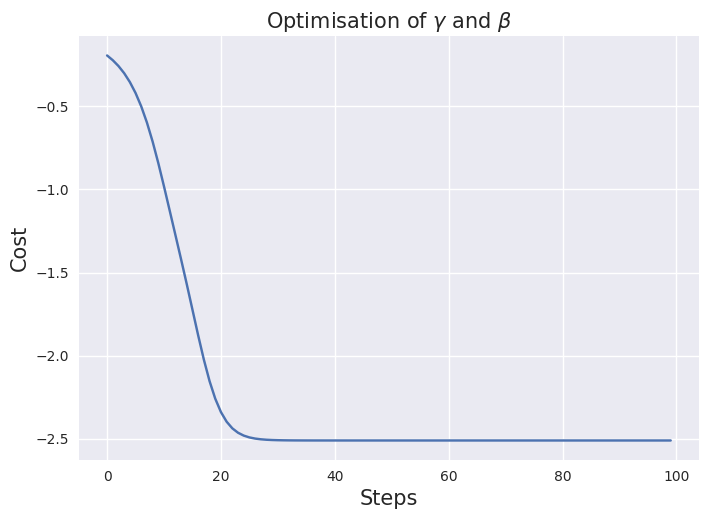

In [23]:
plt.style.use("seaborn")
plt.plot(cost_vector)
plt.xlabel('Steps', fontsize = 15)
plt.ylabel('Cost', fontsize = 15)
plt.title(r'Optimisation of $\gamma$ and $\beta$', fontsize = 15)

In [24]:
# Probability of measuring the different answers
@qml.qnode(dev)
def probability_circuit(params):
    circuit(params)
    return qml.probs(wires=qubits)

probs = probability_circuit(best_params_optimisation)


Success probability of training:  0.15446383088045934


<Figure size 800x550 with 0 Axes>

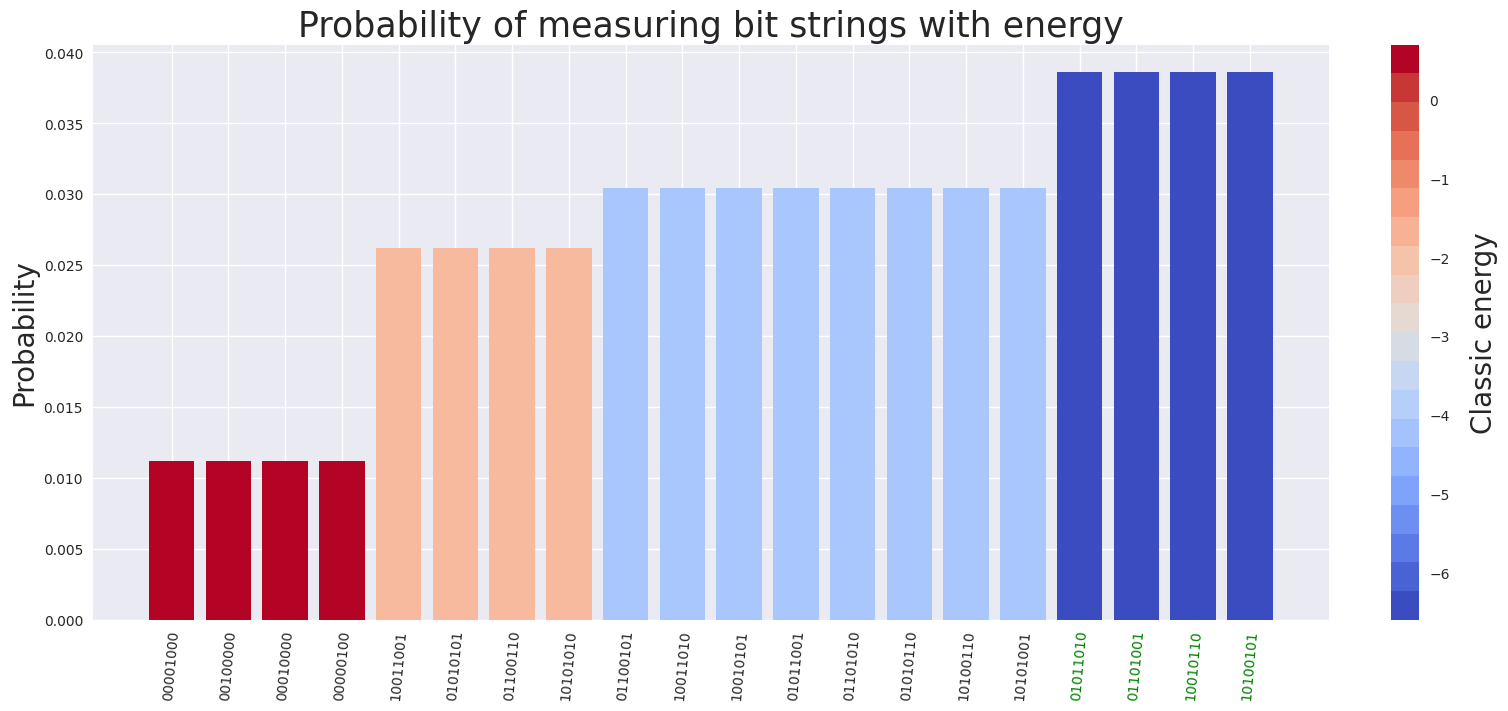

In [25]:
# Fancy plot, the one above is unclar if we succeeded
ground_energy, ground_states_i = get_ground_states_i(feasible_set, H_cost) # get the ground states

print('Success probability of training: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings

/home/jespe/.local/lib/python3.10/site-packages/IPython/core/events.py:89: UserWarning: constrained_layout not applied because axes sizes collapsed to zero.  Try making figure larger or axes decorations smaller.
  func(*args, **kwargs)


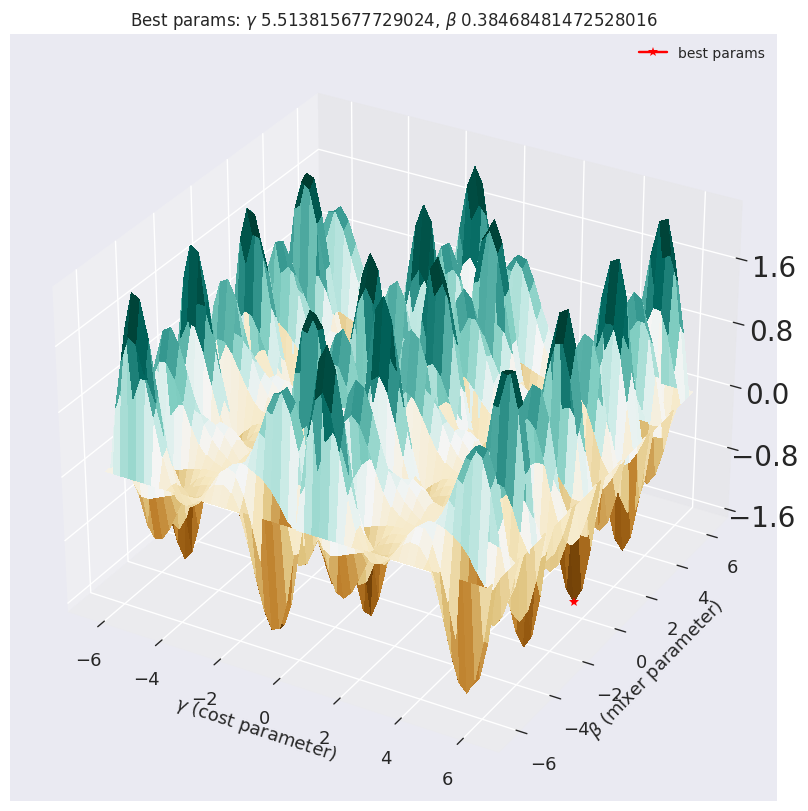

In [36]:
# Grid search
p = 1 # grid search with p > 2 is messy

start_gamma = -2*np.pi
stop_gamma = 2*np.pi
num_points_gamma = 50

start_beta = -2*np.pi
stop_beta = 2*np.pi
num_points_beta = 50

# Gamma
X = np.linspace(start_gamma, stop_gamma, num_points_gamma)
# Beta
Y = np.linspace(start_beta, stop_beta, num_points_beta)

grid_search_params, Z, i = grid_search(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta,
					average_cost,
					above = False,
					save = False)

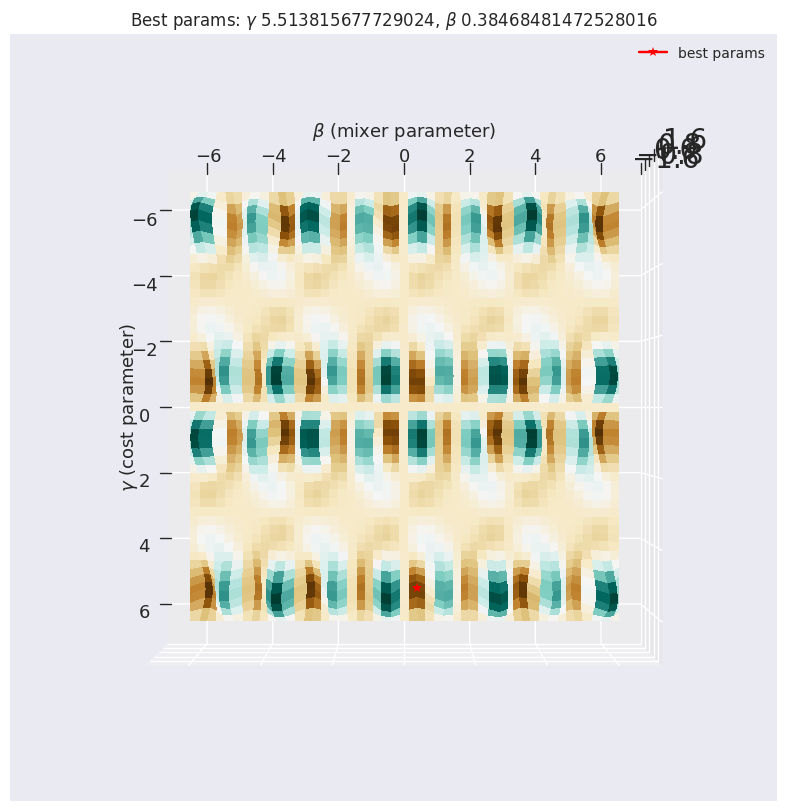

In [37]:
# More plotting, from above

X, Y, _= get_batch_array(start_gamma,
					stop_gamma,
					num_points_gamma,
					start_beta,
					stop_beta,
					num_points_beta)
                
plot_grid_search(X,
					Y,
					Z,
					i,
					above = True,
					name = '',
					save = False)

Success probability of grid search:  0.16189622599429074


<Figure size 800x550 with 0 Axes>

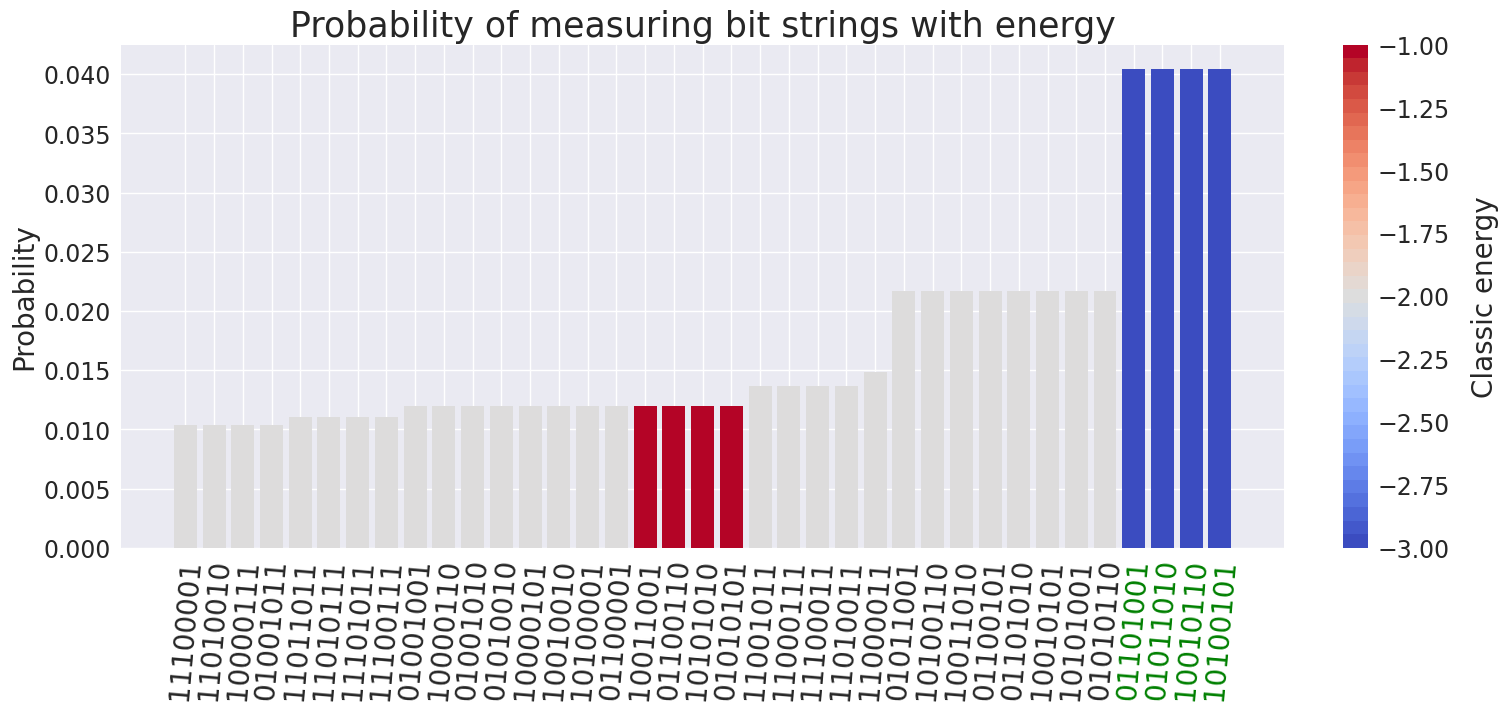

In [38]:
# Is the grid search better?
probs = probability_circuit(grid_search_params)

plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i)

print('Success probability of grid search: ', np.sum(probs[ground_states_i]))

Success probability of annealing parameters:  0.0006163687191462081


<Figure size 800x550 with 0 Axes>

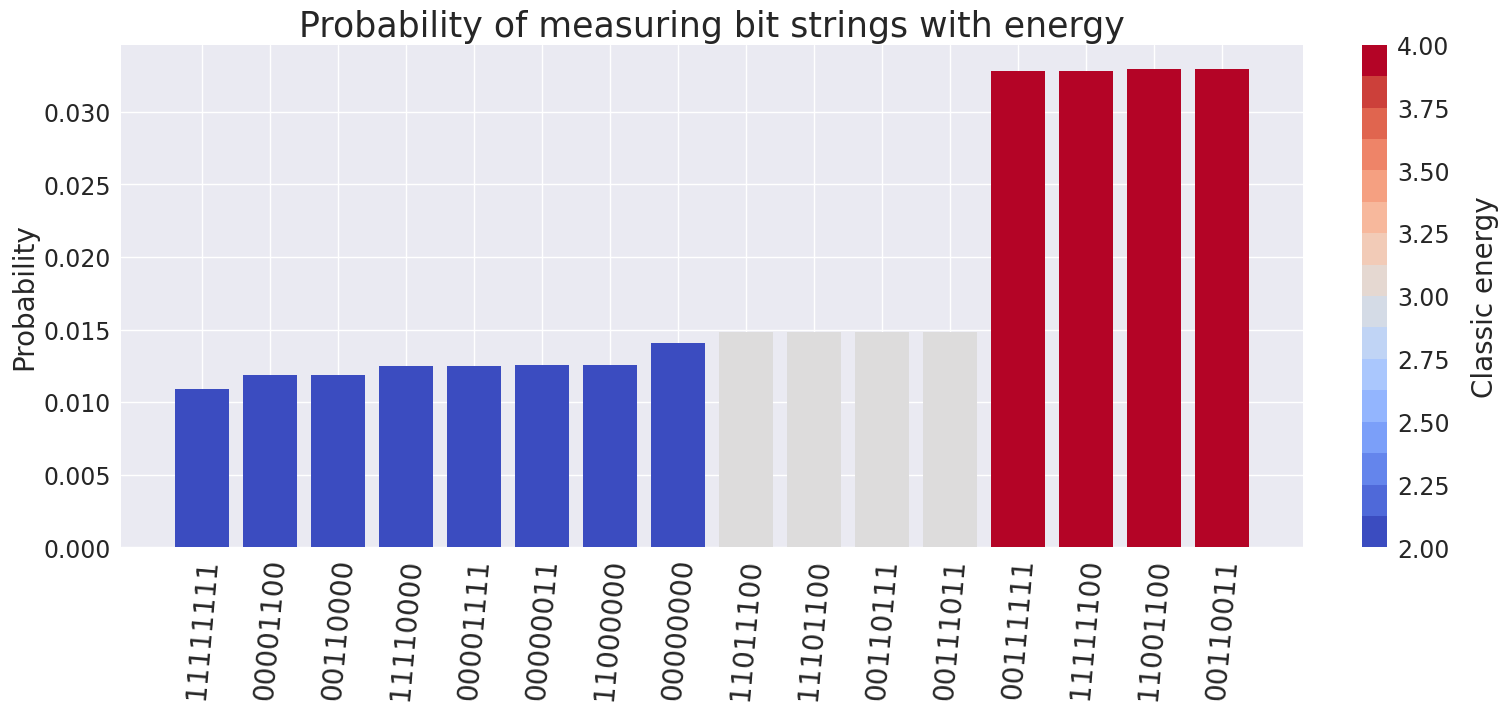

In [39]:
# Or we can do annealing parameters
annealing_params = get_annealing_params(annealing_time=2, p=15, linear = True, cosine = False)
probs = probability_circuit(annealing_params)

print('Success probability of annealing parameters: ', np.sum(probs[ground_states_i]))
plot_probs_with_energy(probs, num_qubits, H_cost, ground_states_i) # plot probability over bitstrings